# Aging aware training

$$ \min_\theta \,\int_{t=0}^{1} \; L(\theta(t)) \, dt $$
where  $\theta(t)$ is a fitted model of the conductance over time

## Monte Carlo approximation:

### Introduction

The goal is to integrate the following formular
$$
\int_t f(t){\rm d}t
$$
Rectangular approximation is 
$$
\sum_n f[n\Delta k]\Delta k
$$
The problem is that, if the sampling rate is lower than twice the frequencce of the function, the error would be large, e.g., integrating a $f(t)=\sin(2\pi (t+\frac{1}{4}))$ with sampling rate $\Delta k=1$, i.e.,
$$
\int_tf(t){\rm d}t\approx\sum_n \sin \left(2\pi (n+\frac{1}{4})\right)=n,
$$
which is obviously wrong.

### Monte Carlo Approximation

Recall the definition of **Expectation** of a distribution
$$
\begin{align}
\mathbb{E}\{x\}&=\int_x x\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N x_n,\ x_n\sim p(x)
\end{align}
$$
Further, 
$$
\begin{align}
\mathbb{E}\{f(x)\}&=\int_x f(x)\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N f(x_n),\ x_n\sim p(x)
\end{align}
$$
For a given integration task $\int_x f(x) {\rm d}x$, we can approximate this by
$$
\int_x f(x) {\rm d}x=\int_x f(x)\cdot 1 {\rm d}x=\int_x f(x)\cdot \frac{p(x)}{p(x)} {\rm d}x=\int_x\frac{f(x)}{p(x)}\cdot p(x) {\rm d}x=\mathbb{E}\left\{\frac{f(x)}{p(x)}\right\}\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)},\ x_n\sim p(x)
$$
Let $p(x)$ is a uniform distribution, e.g., $p(x)=\frac{1}{b-a},\ x\in[a,b]$, we have
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)}=\frac{b-a}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x).
$$
Let $b=1$ and $a=0$, 
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x),
$$
i.e., we can approximate the integration by averaging the randomly sampled value $f(x)$, with $x$ following uniform distribution.

Moreover, the method in the introduction is a special case of Monte Carlo method.
## Aging Aware Training

The goal of aging aware training is
$$
\min_{\theta_{\rm init}} \int_{t=0}^1 L(\theta(t)){\rm d}t,
$$
where $\theta(t)=\theta_{\rm init}\cdot\mathop{A}(t)$ denotes the aging of the resistors. Using Monto Carlo method, it is converted to
$$
\min_{\theta_{\rm init}} \frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right),
$$
where $\mathfrak{K}$ is a set of $K$ uniform randomly sampled timestamps $k\in[0,1]$.

To minimize this function, i.e., $\frac{1}{N}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)$, we apply intuitively the gradient descent:
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot \sum_{k\in \mathfrak{K} } \nabla_{\theta_{\rm init}}\left(L \left(\theta[k]\right)\right)\\
\end{align}
$$

# Get aging model

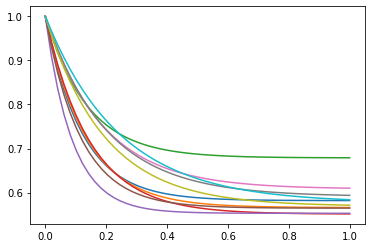

In [1]:
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import data
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))
import torch
from torch.autograd import Variable
import torch.nn.functional as F

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)
vals = np.linspace(0,1)
age_models = age_generator.get_models(10)
for k in age_models:
    plt.plot(vals, k(vals));

## Prepare data

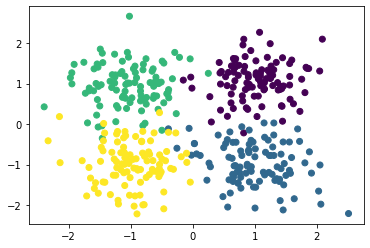

(torch.Size([280, 2]), torch.Size([280]))

In [2]:
np.random.seed(1)
X, Y = data.GenerateData(N=400, var=0.5, plot=True)
X_train, Y_train, X_valid, Y_valid = data.SplitData(X, Y, 0.7)
X_train, Y_train, X_valid, Y_valid = X_train.T, Y_train.T.flatten(), X_valid.T, Y_valid.T.flatten()

x_train, y_train = torch.from_numpy(X_train).type(torch.FloatTensor), torch.from_numpy(Y_train).type(torch.LongTensor)
x_valid, y_valid = torch.from_numpy(X_valid).type(torch.FloatTensor), torch.from_numpy(Y_valid).type(torch.LongTensor)
x_train, y_train = Variable(x_train), Variable(y_train)
x_valid, y_valid = Variable(x_valid), Variable(y_valid)
x_train.shape, y_train.shape

## Try to get aged theta

In [3]:
import importlib
importlib.reload(pnn)

# generate NN, the initial time, i.e., pnn.PNNLayer.t = 0.
mypnn = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                            pnn.PNNLayer(5,5, age_generator),
                            pnn.PNNLayer(5,4, age_generator))
counter = 1
for i in mypnn:
    print(f"The {counter}-th layer:")
    counter += 1
    
    print(f"theta at t={i.t}\n", i.theta_aged)    # print theta
    i.t = 0.1         # change time
    print(f"theta at t={i.t}\n", i.theta_aged)    # print aged theta
    
    print("\n")

The 1-th layer:
theta at t=0
 tensor([[ 0.0000,  0.5927,  8.6628, 39.7779],
        [ 0.0528,  0.6388,  8.3729, 38.4024],
        [ 0.1386,  0.6908, 11.4714, 52.5479],
        [ 0.9068,  0.8776,  3.9805, 17.3749],
        [ 0.1418,  0.2616,  4.1896, 19.1005]], grad_fn=<ViewBackward>)
theta at t=0.1
 tensor([[0.0000e+00, 4.9359e-01, 7.0123e+00, 2.7650e+01],
        [4.1241e-02, 5.3569e-01, 6.8520e+00, 3.0185e+01],
        [1.2019e-01, 5.2787e-01, 9.1108e+00, 4.1990e+01],
        [7.0839e-01, 7.2680e-01, 3.1921e+00, 1.2709e+01],
        [1.1841e-01, 2.0363e-01, 3.2743e+00, 1.5151e+01]],
       grad_fn=<ViewBackward>)


The 2-th layer:
theta at t=0
 tensor([[ 0.0000,  0.8403,  0.6871,  0.4211,  0.3620,  8.1575, 35.5127],
        [ 0.0000,  0.4357,  0.7495,  0.4484,  0.1340,  9.8028, 43.3799],
        [ 0.8794,  0.2732,  0.8268,  0.3095,  0.3714,  4.1205, 16.6360],
        [ 0.7366,  0.7203,  0.6486,  0.6109,  0.9750,  8.0028, 34.0390],
        [ 0.9900,  0.6587,  0.7925,  0.5143,  0.5925,

# Definations

In [4]:
MyAgedPNN = torch.nn.Sequential(pnn.PNNLayer(2,3, age_generator),
                                pnn.PNNLayer(3,3, age_generator),
                                pnn.PNNLayer(3,4, age_generator))
alpha = 0.005
m = 0.3
T = 0.1
K = 35
optimizer_aged = torch.optim.Adam(MyAgedPNN.parameters(), lr=0.1/K)
MyAgedPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [5]:
MyPNN = torch.nn.Sequential(pnn.PNNLayer(2,3, age_generator),
                            pnn.PNNLayer(3,3, age_generator),
                            pnn.PNNLayer(3,4, age_generator))
optimizer = torch.optim.Adam(MyPNN.parameters(), lr=alpha)
MyPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [6]:
myparameter = []
myloss = []
for s in range(2000):
    optimizer.zero_grad()
    
    prediction = MyPNN(x_train)
    loss = pnn.LossFunction(prediction, y_train, m, T)
    loss.backward()
    
    optimizer.step()

    if s % 10 == 0:
        temp = []
        prediction_valid = MyPNN(x_valid)
        p = torch.max(F.softmax(prediction_valid, dim=0), 1)[1]
        pred_y = p.data.numpy().squeeze()
        acc_valid = sum(pred_y == Y_valid) / Y_valid.shape[0]
        loss_valid = pnn.LossFunction(prediction_valid, y_valid, m, T)

        temp = [l.theta_.data.clone() for l in MyPNN]
        myparameter.append(temp)
        myloss.append(loss_valid.data)
        print(f'| Epoch: {s:-6d} | Accuracy: {acc_valid:.5f} | Loss: {loss_valid.data:.5f} |')
print('Finished.')

     0 | Accuracy: 0.48333 | Loss: 0.71565
    10 | Accuracy: 0.50833 | Loss: 0.69699
    20 | Accuracy: 0.67500 | Loss: 0.68132
    30 | Accuracy: 0.69167 | Loss: 0.67009
    40 | Accuracy: 0.69167 | Loss: 0.65733
    50 | Accuracy: 0.70000 | Loss: 0.64409
    60 | Accuracy: 0.69167 | Loss: 0.62827
    70 | Accuracy: 0.75833 | Loss: 0.60646
    80 | Accuracy: 0.84167 | Loss: 0.57603
    90 | Accuracy: 0.86667 | Loss: 0.53658
   100 | Accuracy: 0.90833 | Loss: 0.49407
   110 | Accuracy: 0.93333 | Loss: 0.45358
   120 | Accuracy: 0.92500 | Loss: 0.41407
   130 | Accuracy: 0.92500 | Loss: 0.37411
   140 | Accuracy: 0.92500 | Loss: 0.33449
   150 | Accuracy: 0.93333 | Loss: 0.29685
   160 | Accuracy: 0.93333 | Loss: 0.26057
   170 | Accuracy: 0.93333 | Loss: 0.22334
   180 | Accuracy: 0.94167 | Loss: 0.19324
   190 | Accuracy: 0.94167 | Loss: 0.16923
   200 | Accuracy: 0.94167 | Loss: 0.14684
   210 | Accuracy: 0.94167 | Loss: 0.12881
   220 | Accuracy: 0.94167 | Loss: 0.11529
   230 | Ac

  1910 | Accuracy: 0.95000 | Loss: 0.10495
  1920 | Accuracy: 0.94167 | Loss: 0.10516
  1930 | Accuracy: 0.94167 | Loss: 0.10532
  1940 | Accuracy: 0.94167 | Loss: 0.10552
  1950 | Accuracy: 0.94167 | Loss: 0.10575
  1960 | Accuracy: 0.93333 | Loss: 0.10602
  1970 | Accuracy: 0.93333 | Loss: 0.10619
  1980 | Accuracy: 0.93333 | Loss: 0.10639
  1990 | Accuracy: 0.93333 | Loss: 0.10664
Finished.


tensor(0.0897)

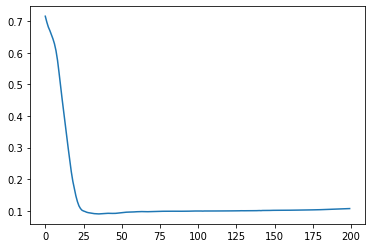

In [7]:
plt.plot(myloss);
best = np.argmin(myloss)
bestparameter = myparameter[best]
for l in range(len(bestparameter)):
    MyPNN[l].theta_.data = bestparameter[l]
prediction_valid = MyPNN(x_valid)
loss_valid = pnn.LossFunction(prediction_valid, y_valid, m, T)
loss_valid.data

In [8]:
myparameter = []
myloss = []
for s in range(2000):
    optimizer_aged.zero_grad()
    
    TimeSet = np.random.rand(K)
    for k in TimeSet:
        for i in MyAgedPNN:
            i.t = k
        prediction = MyAgedPNN(x_train)
        loss = pnn.LossFunction(prediction, y_train, m, T)
        loss.backward()
    
    optimizer_aged.step()

    if s % 10 == 0:
        temp = []
        avg_loss = 0
        avg_acc = 0
        
        test_time = np.linspace(0,1,100)
        for test_t in test_time:
            for i in MyAgedPNN:
                i.t = test_t    
            prediction = MyAgedPNN(x_valid)
            loss = pnn.LossFunction(prediction, y_valid, m, T)
            p = torch.max(F.softmax(prediction, dim=0), 1)[1]
            pred_y = p.data.numpy().squeeze()
            acc = sum(pred_y == Y_valid) / Y_valid.shape[0]
            
            avg_loss += loss.data
            avg_acc += acc
        
        avg_loss /= 100
        avg_acc /= 100
        
        myloss.append(avg_loss)
        temp = [l.theta_.data.clone() for l in MyAgedPNN]
        myparameter.append(temp)
        
        print(f'| Epoch: {s:-6d} | Accuracy: {avg_acc:.5f} | Loss: {avg_loss:.5f} |')

print('Finished.')

     0 | Accuracy: 0.43200 | Loss: 1.40595
    10 | Accuracy: 0.43325 | Loss: 1.39472
    20 | Accuracy: 0.40875 | Loss: 1.38398
    30 | Accuracy: 0.35642 | Loss: 1.37185
    40 | Accuracy: 0.27208 | Loss: 1.35271
    50 | Accuracy: 0.20092 | Loss: 1.31091
    60 | Accuracy: 0.20483 | Loss: 1.21692
    70 | Accuracy: 0.25975 | Loss: 1.08466
    80 | Accuracy: 0.28983 | Loss: 1.04199
    90 | Accuracy: 0.30192 | Loss: 1.01398
   100 | Accuracy: 0.23317 | Loss: 0.97627
   110 | Accuracy: 0.17017 | Loss: 0.95367
   120 | Accuracy: 0.15850 | Loss: 0.93568
   130 | Accuracy: 0.25142 | Loss: 0.91398
   140 | Accuracy: 0.34383 | Loss: 0.89612
   150 | Accuracy: 0.51258 | Loss: 0.88078
   160 | Accuracy: 0.55425 | Loss: 0.86857
   170 | Accuracy: 0.57325 | Loss: 0.85961
   180 | Accuracy: 0.59458 | Loss: 0.84849
   190 | Accuracy: 0.60975 | Loss: 0.84122
   200 | Accuracy: 0.62200 | Loss: 0.83386
   210 | Accuracy: 0.63500 | Loss: 0.82456
   220 | Accuracy: 0.65075 | Loss: 0.81525
   230 | Ac

  1910 | Accuracy: 0.94333 | Loss: 0.09181
  1920 | Accuracy: 0.94333 | Loss: 0.09152
  1930 | Accuracy: 0.94342 | Loss: 0.09123
  1940 | Accuracy: 0.94342 | Loss: 0.09154
  1950 | Accuracy: 0.94317 | Loss: 0.09212
  1960 | Accuracy: 0.94308 | Loss: 0.09213
  1970 | Accuracy: 0.94325 | Loss: 0.09218
  1980 | Accuracy: 0.94317 | Loss: 0.09198
  1990 | Accuracy: 0.94308 | Loss: 0.09238
Finished.


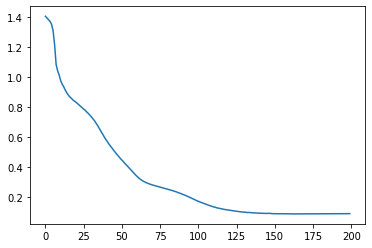

In [9]:
plt.plot(myloss);
best = np.argmin(myloss)
bestparameter = myparameter[best]
for l in range(len(bestparameter)):
    MyAgedPNN[l].theta_.data = bestparameter[l]

In [10]:
import evaluation
import importlib
importlib.reload(evaluation)

test_time = np.linspace(0,1,100)
my_aged_acc = []
my_acc = []
my_aged_maa = []
my_maa = []

for test_t in test_time:
    for i in MyAgedPNN:
        i.t = test_t
    for i in MyPNN:
        i.t = test_t
    
    my_aged_acc.append(evaluation.basic(MyAgedPNN, x_valid, y_valid))
    my_acc.append(evaluation.basic(MyPNN, x_valid, y_valid))
    
    my_aged_maa.append(evaluation.maa(MyAgedPNN, x_valid, y_valid))
    my_maa.append(evaluation.maa(MyPNN, x_valid, y_valid))

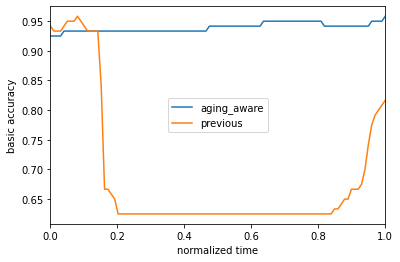

In [11]:
plt.plot(test_time, my_aged_acc, label='aging_aware');
plt.plot(test_time, my_acc, label='previous');
plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

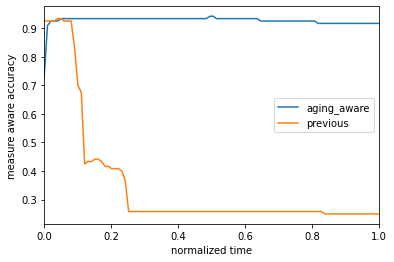

In [12]:
plt.plot(test_time, my_aged_maa, label='aging_aware');
plt.plot(test_time, my_maa, label='previous');
plt.xlabel('normalized time');
plt.ylabel('measure aware accuracy');
plt.xlim([0, 1])
plt.legend();

# Aging Aware with various Aging Models
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

In [13]:
MyAgedPNN[0].model = generator.get_model(10)

NameError: name 'generator' is not defined

In [ ]:
plt.fillbetween(x, mean_acc - std_acc, mean_acc + std_acc, alpha=0.3)